In [68]:
import os,sys,glob,time
smodelsPath = os.path.expanduser('~/smodels')
sys.path.append(smodelsPath)
from smodels.theory.auxiliaryFunctions import rescaleWidth, unscaleWidth
import numpy as np
from trimRegularGrid import trim1D, testTrimmedGrid, removeWidth
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.spatial import ConvexHull,Delaunay
from scipy.interpolate import griddata
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))
cm = plt.cm.get_cmap('RdYlBu')

In [78]:
nx = 10
ny = 10
xy = []
for x in np.linspace(0, 1, nx):
    for y in np.linspace(0, 1, ny):
        xy.append([x,y])

xy = np.array(xy)
yvals = (xy[:,0]**2+xy[:,1]**2)**2

In [72]:
def trimGrid(points,values,minY = 1e-2,maxDiff = 5e-2,random=True):

    t0 = time.time()

    #Replace all small values by zero:
    values = np.where(values > minY,values,0.0)
    #Get triangulation:
    tri = Delaunay(points)
    #Get convex hull
    cHullvertices = list(set(tri.convex_hull.flatten()))
    #Get info about neighbors:
    indptr,indices = tri.vertex_neighbor_vertices

    indexKeep = []
    rmvPts = set()

    #If random = True, randomly walk through the grid:
    if random:
        indexList = np.random.permutation(len(tri.points))
    else:
        indexList = np.arange(len(tri.points))

 
    for counter,i in enumerate(indexList):
        if i in cHullvertices or i in rmvPts:
            indexKeep.append(i)
            continue #Do not remove pts in the convexhull or of simplices which already had a point removed

        #Get the neighbors to the point
        neighbors = indices[indptr[i]:indptr[i+1]]
        #Using a linear interpolator with neighbors check interpolation value at point i
        y_interp = griddata(tri.points[neighbors],values[neighbors],tri.points[i],method='linear')[0]
        y = values[i]

        if y < minY:
            diff = max(0,(y_interp-minY)/minY) #For values smaller than minY, just require y_interp < (1+maxDiff)*minY
        else:
            diff = abs(y_interp-y)/y #Relative difference

        if diff > maxDiff:
            keepPoint = True
        else:
            keepPoint = False
            
        if not keepPoint:
            for ii in neighbors:
                #Get next-neighbors
                nneighbors = np.hstack(neighbors,indices[indptr[ii]:indptr[ii+1]])
                nneighors = np.unique(nneighors[nneighors != ii])
                y_interp = griddata(tri.points[nneighors],values[nneighors],tri.points[ii],method='linear')[0]
                y = values[i]

                if y < minY:
                    diff = max(0,(y_interp-minY)/minY) #For values smaller than minY, just require y_interp < (1+maxDiff)*minY
                else:
                    diff = abs(y_interp-y)/y #Relative difference

                if diff > maxDiff:
                    keepPoint = True
                else:
                    keepPoint = False
                

        if keepPoint:
            indexKeep.append(i)
        else:
            rmvPts.add(i)
            rmvPts = rmvPts.union(neighbors)

    print('Data successfully trimmed down to %1.0f%% (%i/%i) in %1.1f min' %(100.0*len(indexKeep)/len(points),
                                                                                  len(indexKeep),len(points),
                                                                                  (time.time()-t0)/60.))


    return indexKeep


In [79]:
keepPts = trimGrid(xy,yvals,maxDiff=0.2,random=False)

Data successfully trimmed down to 81% (81/100) in 0.0 min


In [80]:
tri = Delaunay(xy)
cHullvertices = list(set(tri.convex_hull.flatten()))

In [81]:
newPts = xy[keepPts]
newVals = yvals[keepPts]
triNew = Delaunay(newPts)
cHullverticesNew = list(set(triNew.convex_hull.flatten()))
y_interp = griddata(newPts,newVals,tri.points)

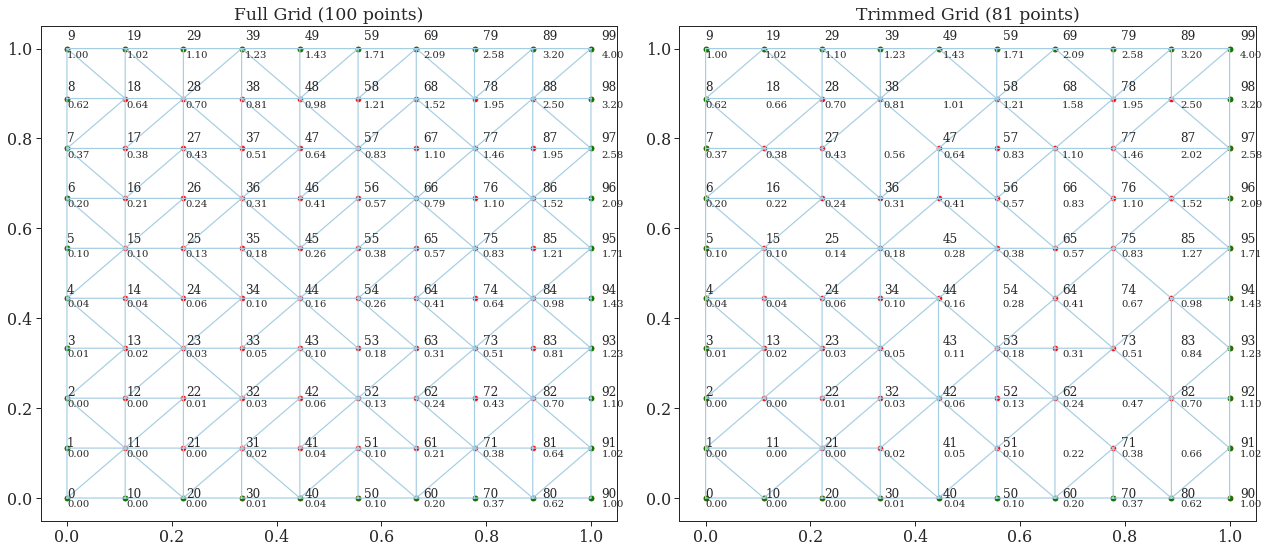

In [82]:
fig,ax = plt.subplots(ncols=2,figsize=(18,8))

ax[0].triplot(tri.points[:,0], tri.points[:,1], tri.simplices.copy())
ax[0].scatter(tri.points[:,0],tri.points[:,1],color='red')
ax[0].scatter(tri.points[cHullvertices][:,0],tri.points[cHullvertices][:,1],color='green')
for i,pt in enumerate(xy):
    ax[0].annotate('%i'%i,(1.02*pt[0],1.02*pt[1]), fontsize=12)
    ax[0].annotate('%1.2f'%yvals[i],(1.02*pt[0],pt[1]-0.02), fontsize=10)
    
ax[0].set_title('Full Grid (%i points)' %len(xy))    


ax[1].triplot(triNew.points[:,0], triNew.points[:,1], triNew.simplices.copy())
ax[1].scatter(triNew.points[:,0],triNew.points[:,1],color='red')
ax[1].scatter(triNew.points[cHullverticesNew][:,0],triNew.points[cHullverticesNew][:,1],color='green')
for i in inewPts:
    ax[1].annotate('%i'%i,(1.02*tri.points[i][0],1.02*tri.points[i][1]), fontsize=12)
for i,pt in enumerate(tri.points):    
    ax[1].annotate('%1.2f'%y_interp[i],(1.02*tri.points[i][0],tri.points[i][1]-0.02), fontsize=10)    

ax[1].set_title('Trimmed Grid (%i points)' %len(newPts))    

plt.tight_layout()
plt.show()

In [40]:
(abs(yvals-y_interp)/yvals).max()

0.17642903329524168

In [29]:
indptr,indices = tri.vertex_neighbor_vertices

indices[indptr[32]:indptr[32+1]]

array([31, 42, 23, 22, 33, 21, 43], dtype=int32)

In [63]:
print(tri.simplices[tri.vertex_to_simplex[32]])
for isimplex in tri.neighbors[tri.vertex_to_simplex[32]]:
    print(isimplex,tri.simplices[isimplex])

[32 31 42]
14 [31 41 42]
102 [43 32 42]
96 [21 31 32]


In [89]:
x = np.array([1,2,3])
y = np.array([4,5,1])
np.unique(np.hstack((x,y)))

array([1, 2, 3, 4, 5])